In [ ]:
# 데이터
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import mode

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 모델
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#평가
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Data Load

In [ ]:
def data_load():
  df_list = []

  for i in range(0, 10):
      path = f"/content/drive/MyDrive/Colab Notebooks/ML programming/data/MHEALTHDATASET/mHealth_subject{i+1}.log"
      df = pd.read_csv(path, sep='\t', header=None)
      df['subject'] = i+1
      df.rename(columns={df.columns[23]: 'activity'}, inplace=True)
      # activit 0번 : 0 for the null class 삭제
      df = df[df['activity'] != 0]
      df['activity'] = df['activity'] - 1
      df_list.append(df)

  df_all = pd.concat(df_list, ignore_index=True)
  return df_all

In [ ]:
df = data_load()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,activity,subject
0,-9.7788,0.55690,1.19750,0.008373,-0.033490,2.6493,-9.4517,0.37683,-0.20965,-0.88931,...,-9.0618,1.8177,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,0,1
1,-9.7733,0.27880,0.73036,-0.025118,-0.025118,2.4157,-9.5306,0.40179,-0.20965,-0.88931,...,-9.2048,1.5189,-0.058824,-0.93429,-0.34483,0.719910,0.17803,0.37363,0,1
2,-9.8609,0.11561,0.79988,0.025118,0.016745,2.3865,-9.5991,0.48141,-0.20037,-0.86867,...,-9.1945,1.5507,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,0,1
3,-9.7409,0.17652,0.88957,0.180010,0.129770,2.3758,-9.5997,0.42919,-0.20037,-0.86867,...,-9.1746,1.5413,-0.078431,-0.93429,-0.34052,0.357180,-0.18858,-0.35198,0,1
4,-9.7821,0.21637,0.90368,0.092098,0.046049,2.3239,-9.5406,0.40038,-0.20037,-0.86867,...,-9.2039,1.6127,-0.078431,-0.93429,-0.34052,-0.001887,-0.18867,-0.72017,0,1


In [ ]:
df.shape

(343195, 25)

## EDA

/tmp/ipython-input-2038512996.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')


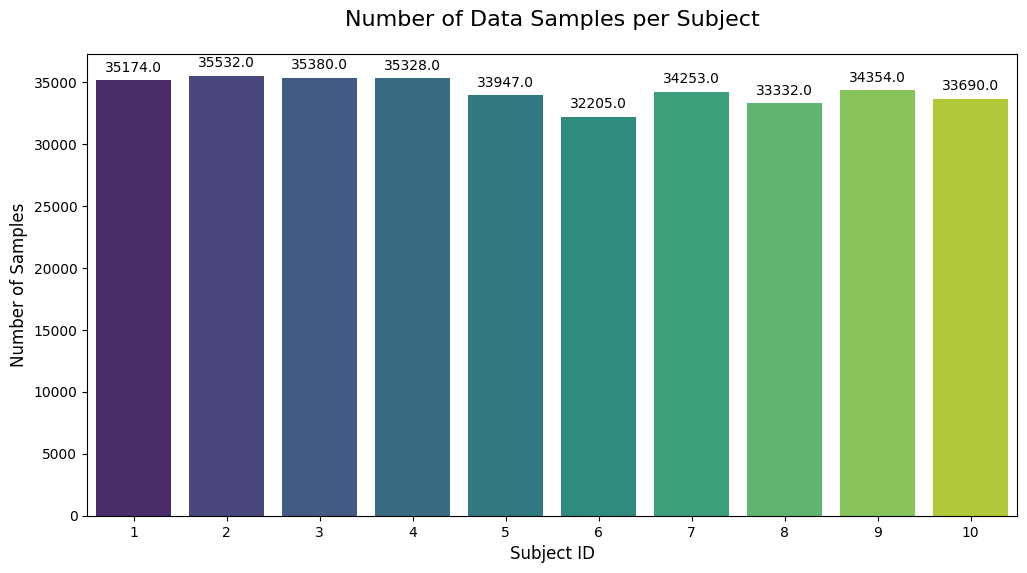

In [ ]:
subject_counts = df['subject'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

ax = sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')

plt.title('Number of Data Samples per Subject', fontsize=16, pad=20)
plt.xlabel('Subject ID', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

/tmp/ipython-input-1749881800.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')


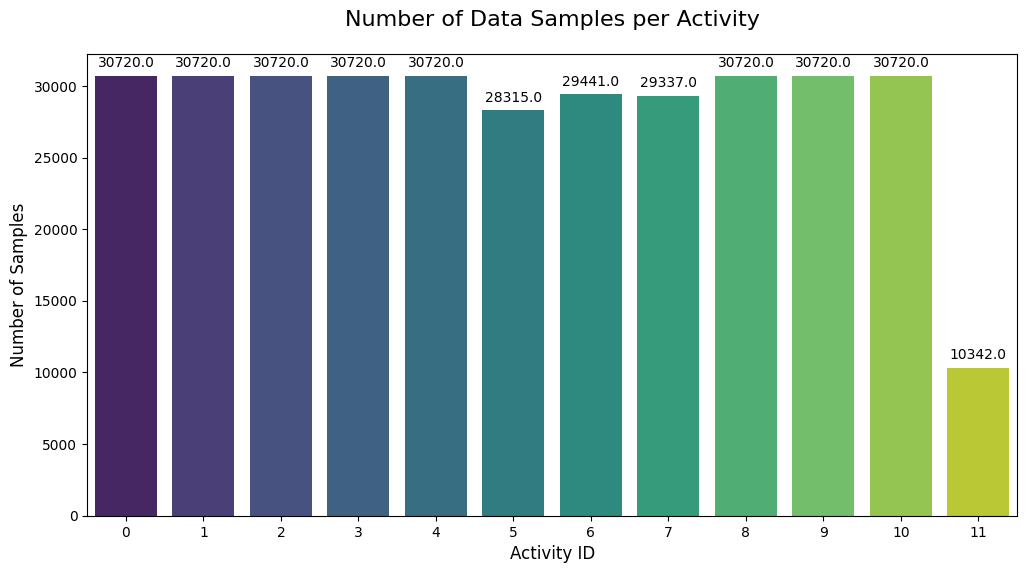

In [ ]:
subject_counts = df['activity'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

ax = sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')

plt.title('Number of Data Samples per Activity', fontsize=16, pad=20)
plt.xlabel('Activity ID', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

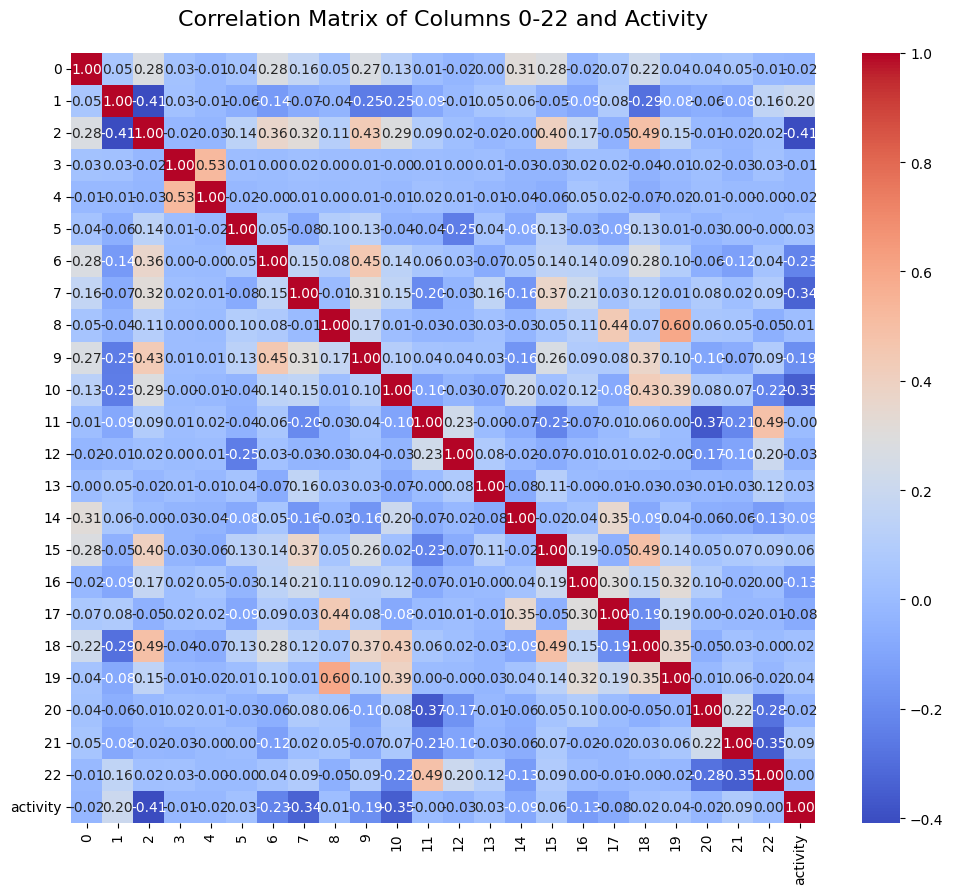

In [ ]:
# Calculate the correlation matrix between columns 0-22 and 'activity'
correlation_matrix = df.loc[:, list(range(23)) + ['activity']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Columns 0-22 and Activity', fontsize=16, pad=20)
plt.show()

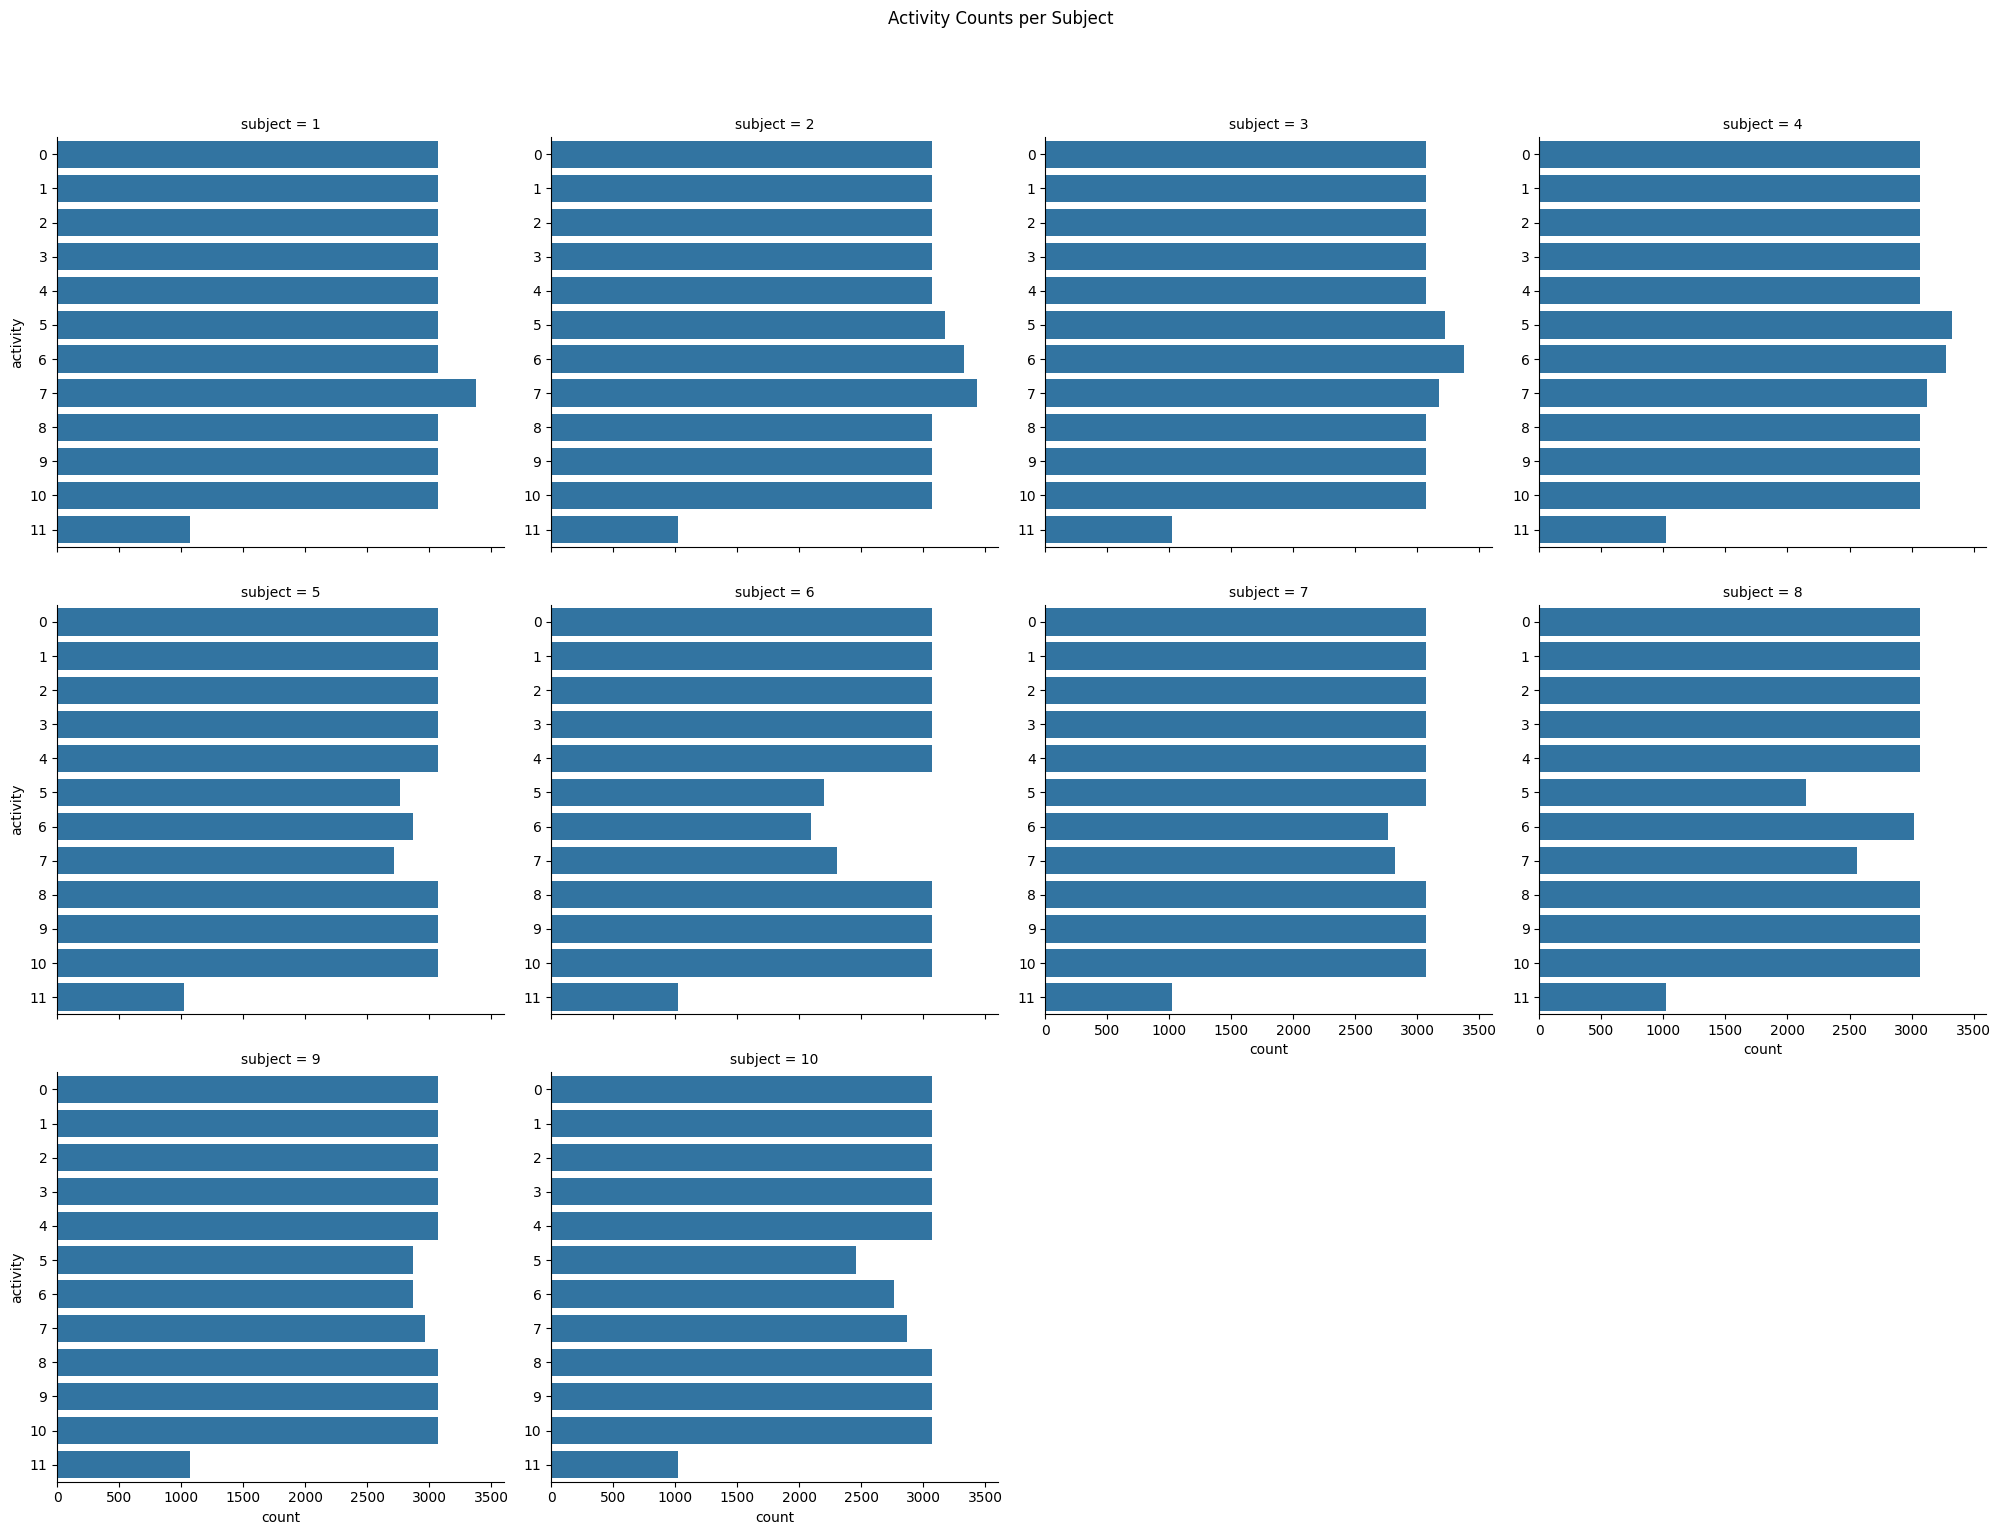

In [ ]:
g = sns.catplot(data=df, y='activity', col='subject', kind='count',
                height=5, aspect=1, col_wrap=4, sharey=False)

g.fig.suptitle('Activity Counts per Subject', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Preprocessing

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features_data, labels_data, frame_size, hop_size):
        """
        초기화 메서드.
        - features_data: 피처 데이터 (Pandas DataFrame 또는 NumPy ndarray)
        - labels_data: 라벨 데이터 (Pandas Series 또는 NumPy ndarray)
        """
        # 입력 데이터가 Pandas 객체이면 .values로 NumPy 배열을 추출하고,
        # 이미 NumPy 배열이면 그대로 사용합니다.
        self.features = features_data.values if hasattr(features_data, 'values') else features_data
        self.labels = labels_data.values if hasattr(labels_data, 'values') else labels_data

        self.frame_size = frame_size
        self.hop_size = hop_size

        self.num_frames = (len(self.features) - frame_size) // hop_size + 1

    def __len__(self):
        return self.num_frames

    def __getitem__(self, idx):
        start_idx = idx * self.hop_size
        end_idx = start_idx + self.frame_size

        frame = self.features[start_idx:end_idx]
        label_window = self.labels[start_idx:end_idx]
        label = mode(label_window)[0]

        frame_tensor = torch.tensor(frame, dtype=torch.float32).permute(1, 0)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return frame_tensor, label_tensor

In [ ]:
# train, test 분할
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :22], df['activity'], test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((274556, 22), (68639, 22), (274556,), (68639,))

In [ ]:
# train, val 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((205917, 22), (68639, 22), (205917,), (68639,))

In [ ]:
# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((205917, 22), (68639, 22), (68639, 22))

## Defining Model

In [ ]:
class CNN1D(nn.Module):
    def __init__(self, input_channels, num_classes, frame_size):
        super(CNN1D, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        final_channels = 64
        final_seq_length = frame_size // 4
        flattened_size = final_channels * final_seq_length

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        """
        Input x shape: (batch_size, input_channels, frame_size)
        """
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.fc_layers(x)
        return x


## Training

In [ ]:
FRAME_SIZE = 80
HOP_SIZE = 40
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.0001
PATIENCE = 5
INPUT_CHANNELS = 22
NUM_CLASSES = 12

In [ ]:
# 슬라이딩 윈도우 분할 후 텐서로 변환


train_dataset = TimeSeriesDataset(X_train_scaled, y_train, frame_size=FRAME_SIZE, hop_size=HOP_SIZE)
val_dataset = TimeSeriesDataset(X_val_scaled, y_val, frame_size=FRAME_SIZE, hop_size=HOP_SIZE)
test_dataset = TimeSeriesDataset(X_test_scaled, y_test, frame_size=FRAME_SIZE, hop_size=HOP_SIZE)

print("TimeSeriesDataset Creation Done:")
print(f"Number of frames in Train Dataset: {len(train_dataset)}")
print(f"Number of frames in Validation Dataset: {len(val_dataset)}")
print(f"Number of frames in Test Dataset: {len(test_dataset)}")
print("-" * 50)

TimeSeriesDataset Creation Done:
Number of frames in Train Dataset: 5146
Number of frames in Validation Dataset: 1714
Number of frames in Test Dataset: 1714
--------------------------------------------------


In [ ]:
# DataLoader로 감싸서 모델 학습에 사용
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 첫 번째 배치 데이터 확인
features_batch, labels_batch = next(iter(train_loader))
print(f"\nDataLoader 배치 피처 텐서 모양: {features_batch.shape}") # (batch_size, num_features, frame_size)
print(f"DataLoader 배치 라벨 텐서 모양: {labels_batch.shape}") # (batch_size)


DataLoader 배치 피처 텐서 모양: torch.Size([64, 22, 80])
DataLoader 배치 라벨 텐서 모양: torch.Size([64])


In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN1D(input_channels=INPUT_CHANNELS, num_classes=NUM_CLASSES, frame_size=FRAME_SIZE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path='best_model_checkpoint.pt')

history = {'train_loss': [], 'val_loss': [], 'val_acc': []}


# --- 학습 루프 ---
for epoch in range(1, EPOCHS + 1):
    # 2️⃣. Training 단계
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # 3️⃣. Validation 단계
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 4️⃣. 에포크 통계 계산 및 출력
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = accuracy_score(all_labels, all_preds)

    print(f'Epoch {epoch}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}')

    # 5️⃣. History에 현재 에포크 결과 추가
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    # 6️⃣. Early Stopping 확인
    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# --- 최적 모델 로드 ---
print("\nLoading the best model state from checkpoint...")
model.load_state_dict(torch.load('best_model_checkpoint.pt'))
print("Best model loaded successfully.")



Epoch 1/100 | Train Loss: 2.4317 | Val Loss: 2.3767 | Val Acc: 0.1336
Validation loss decreased (inf --> 2.376681).  Saving model ...
Epoch 2/100 | Train Loss: 2.3728 | Val Loss: 2.3478 | Val Acc: 0.1552
Validation loss decreased (2.376681 --> 2.347805).  Saving model ...
Epoch 3/100 | Train Loss: 2.3212 | Val Loss: 2.3045 | Val Acc: 0.1884
Validation loss decreased (2.347805 --> 2.304450).  Saving model ...
Epoch 4/100 | Train Loss: 2.2529 | Val Loss: 2.2523 | Val Acc: 0.2135
Validation loss decreased (2.304450 --> 2.252323).  Saving model ...
Epoch 5/100 | Train Loss: 2.1854 | Val Loss: 2.2008 | Val Acc: 0.2287
Validation loss decreased (2.252323 --> 2.200835).  Saving model ...
Epoch 6/100 | Train Loss: 2.0997 | Val Loss: 2.1635 | Val Acc: 0.2264
Validation loss decreased (2.200835 --> 2.163541).  Saving model ...
Epoch 7/100 | Train Loss: 2.0479 | Val Loss: 2.1520 | Val Acc: 0.2258
Validation loss decreased (2.163541 --> 2.151977).  Saving model ...


KeyboardInterrupt: 

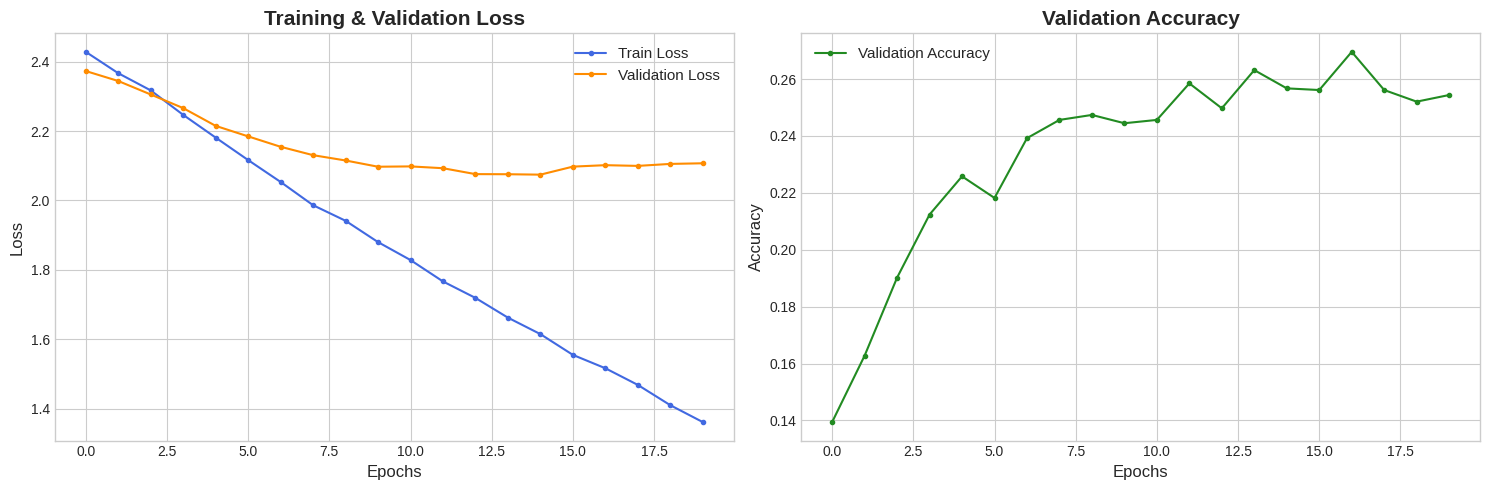

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
# 그래프 크기 설정
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Loss 그래프 ---
ax1.plot(history['train_loss'], label='Train Loss', color='royalblue', marker='o', markersize=3)
ax1.plot(history['val_loss'], label='Validation Loss', color='darkorange', marker='o', markersize=3)
ax1.set_title('Training & Validation Loss', fontsize=15, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True)

# --- Accuracy 그래프 ---
ax2.plot(history['val_acc'], label='Validation Accuracy', color='forestgreen', marker='o', markersize=3)
ax2.set_title('Validation Accuracy', fontsize=15, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True)

# --- 전체 레이아웃 조정 및 출력 ---
plt.tight_layout()
plt.show()


--- Test Results ---
Test Loss: 2.0738
Test Accuracy: 0.2468

--- Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.22      0.44      0.30       217
     Class 1       0.16      0.16      0.16       188
     Class 2       0.58      0.63      0.60       240
     Class 3       0.04      0.05      0.05       149
     Class 4       0.16      0.12      0.13       187
     Class 5       0.17      0.07      0.10        96
     Class 6       0.14      0.02      0.04       128
     Class 7       0.18      0.04      0.06       105
     Class 8       0.30      0.31      0.30       154
     Class 9       0.13      0.14      0.14       115
    Class 10       0.28      0.30      0.29       135
    Class 11       0.00      0.00      0.00         0

    accuracy                           0.25      1714
   macro avg       0.20      0.19      0.18      1714
weighted avg       0.24      0.25      0.23      1714

--- Confusion Matrix ---


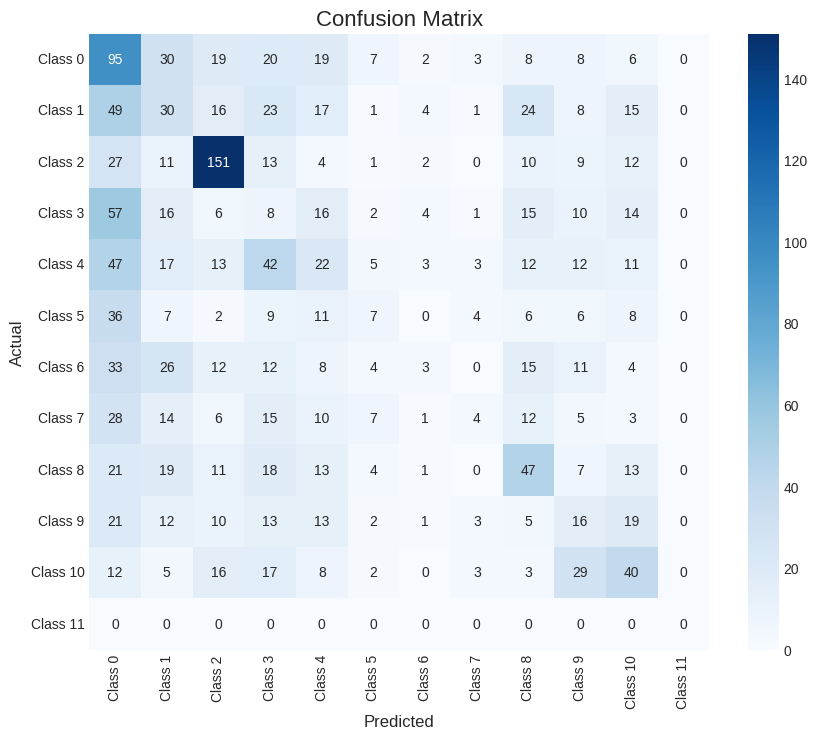

In [ ]:
# 1. 클래스 이름과 전체 라벨 리스트 정의
class_names = [f'Class {i}' for i in range(NUM_CLASSES)]
all_possible_labels = list(range(NUM_CLASSES)) # e.g., [0, 1, ..., 11]

# 2. 모델을 평가 모드로 설정
model.eval()

# 3. 변수 초기화
test_loss = 0.0
all_preds = []
all_labels = []

# 4. 평가 루프 (그래디언트 계산 비활성화)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 5. 최종 성능 지표 계산 및 출력
avg_test_loss = test_loss / len(test_loader.dataset)
test_accuracy = accuracy_score(all_labels, all_preds)

print("--- Test Results ---")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}\n")

# 6. Classification Report 출력 (labels 파라미터 추가)
print("--- Classification Report ---")
print(classification_report(all_labels, all_preds,
                            target_names=class_names,
                            labels=all_possible_labels,
                            zero_division=0))

# 7. Confusion Matrix 시각화 (labels 파라미터 추가)
print("--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds, labels=all_possible_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()